In [1]:
!pip install optuna
!pip install japanize_matplotlib

In [2]:
import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import optuna

In [3]:
input_file ="../data/sales_data.csv"
df = pd.read_csv(input_file)
df.head()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
0,9/7/15,"5,554,981",58.86750,20340000,5890000,"23,080",Actual
1,9/14/15,"6,071,669",235.18125,15470000,5740000,"29,979",Actual
2,9/21/15,"5,798,657",252.18375,8325000,0,"23,784",Actual
3,9/28/15,"6,235,157",75.25500,0,0,"26,732",Actual
4,10/5/15,"6,861,105",0.00000,0,0,"28,823",Actual


In [4]:
df.tail()

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type
116,11/27/17,NaN,79.3800,15450000,0,"31,769",Forecast
117,12/4/17,NaN,41.4900,9930000,0,"34,799",Forecast
118,12/11/17,NaN,0.0000,16280000,0,"31,907",Forecast
119,12/18/17,NaN,81.2625,13350000,5890000,"31,048",Forecast
120,12/25/17,NaN,44.5725,15030000,9150000,"59,196",Forecast


# Preprocess

In [5]:
df.isnull().sum()

Date            0
Sales          16
TVCM_GPR        0
Print_Media     0
Offline_Ads     0
Digital_Ads     0
Record_Type     0
dtype: int64

In [6]:
df.duplicated(subset=['Date']).sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        105 non-null    object 
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    object 
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 6.7+ KB


In [8]:
df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         121 non-null    object 
 1   Sales        121 non-null    int64  
 2   TVCM_GPR     121 non-null    float64
 3   Print_Media  121 non-null    int64  
 4   Offline_Ads  121 non-null    int64  
 5   Digital_Ads  121 non-null    int64  
 6   Record_Type  121 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 6.7+ KB


# Add Monthly Dummy

In [9]:
import pandas as pd
import numpy as np

df['Date'] = pd.to_datetime(df['Date'])

def count_days_in_week(start_date):
    counts = {f'{i}月': 0 for i in range(1, 13)}
    for i in range(7):
        current_day = start_date + pd.Timedelta(days=i)
        month_str = f'{current_day.month}月'
        counts[month_str] += 1
    return pd.Series(counts)

dummy_columns = [f'{i}月' for i in range(1, 13)]

if not all(col in df.columns for col in dummy_columns):
    month_dummies = df['Date'].apply(count_days_in_week)
    df = pd.concat([df, month_dummies], axis=1)
else:
    print("Monthly dummy columns already exist. Skipping concatenation.")

print(df.tail(20))

          Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
101 2017-08-14  6424589    0.00000     12785000            0        51122   
102 2017-08-21  5308052   39.29250     12510000            0        45519   
103 2017-08-28  5637103    0.00000     12890000            0        33703   
104 2017-09-04  6250997   36.44250     15080000            0        38845   
105 2017-09-11        0  235.18125     15470000      5740000        23830   
106 2017-09-18        0  252.18375      8325000            0        26072   
107 2017-09-25        0   75.25500            0            0        29948   
108 2017-10-02        0    0.00000            0            0        34220   
109 2017-10-09        0   44.62125            0            0        29145   
110 2017-10-16        0   50.16750            0            0        25991   
111 2017-10-23        0   46.60875            0      8360000        18571   
112 2017-10-30        0  115.46625     15900000      8710000        32704   

/var/folders/_n/cr9xqtgn70g_tclcyk9hd0nw0000gn/T/ipykernel_49649/3108959876.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


# Add Public Holiday Dummy

In [10]:
from datetime import datetime, timedelta

holiday_ranges = {
    '正月': [
        (datetime(2015,12,28), datetime(2016,1,3)),
        (datetime(2016,12,26), datetime(2017,1,3)),
        (datetime(2017,12,25), datetime(2018,1,3)),  # Extend if needed
    ],
    'GW': [
        (datetime(2015,4,29), datetime(2015,5,5)),
        (datetime(2016,4,29), datetime(2016,5,5)),
        (datetime(2017,4,29), datetime(2017,5,5)),
    ],
    'お盆': [
        (datetime(2015,8,13), datetime(2015,8,16)),
        (datetime(2016,8,13), datetime(2016,8,16)),
        (datetime(2017,8,13), datetime(2017,8,16)),
    ]
}

df['正月'] = 0
df['GW'] = 0
df['お盆'] = 0

def intersects_holiday(week_start, holiday_start, holiday_end):
    """
    Returns True if the 7-day window [week_start, week_start+6] intersects
    with [holiday_start, holiday_end].
    """
    week_end = week_start + pd.Timedelta(days=6)
    return not (week_end < holiday_start or week_start > holiday_end)

for idx, row in df.iterrows():
    week_start = row['Date']
    
    for holiday_name, ranges in holiday_ranges.items():
        for (start_date, end_date) in ranges:
            if intersects_holiday(week_start, start_date, end_date):
                df.loc[idx, holiday_name] = 1
                break 

print(df.head(15))

         Date    Sales   TVCM_GPR  Print_Media  Offline_Ads  Digital_Ads  \
0  2015-09-07  5554981   58.86750     20340000      5890000        23080   
1  2015-09-14  6071669  235.18125     15470000      5740000        29979   
2  2015-09-21  5798657  252.18375      8325000            0        23784   
3  2015-09-28  6235157   75.25500            0            0        26732   
4  2015-10-05  6861105    0.00000            0            0        28823   
5  2015-10-12  5987676   44.62125            0            0        24929   
6  2015-10-19  5975534   50.16750            0            0        29918   
7  2015-10-26  5996415   46.60875            0      8360000        25121   
8  2015-11-02  5712700  115.46625     15900000      8710000        25303   
9  2015-11-09  5863532  185.66250      7835000      9050000        26184   
10 2015-11-16  6169764  223.53375      8405000      9600000        32256   
11 2015-11-23  6721802  188.91000     23295000      4690000        33227   
12 2015-11-3

# Add Time lag

In [11]:
df['Offline_Ads_Lag1'] = df['Offline_Ads'].shift(1)
df['Offline_Ads_Lag1'] = df['Offline_Ads_Lag1'].fillna(0)

print(df[['Date', 'Offline_Ads', 'Offline_Ads_Lag1']].head(10))

        Date  Offline_Ads  Offline_Ads_Lag1
0 2015-09-07      5890000               0.0
1 2015-09-14      5740000         5890000.0
2 2015-09-21            0         5740000.0
3 2015-09-28            0               0.0
4 2015-10-05            0               0.0
5 2015-10-12            0               0.0
6 2015-10-19            0               0.0
7 2015-10-26      8360000               0.0
8 2015-11-02      8710000         8360000.0
9 2015-11-09      9050000         8710000.0


# Add Residual Effect with Optina Tuning

In [12]:
def add_residual_effect(df, col, lambda_val, max_lag=4):
    """
    指定した列(col)に対して、残存効果（ジオメトリックディケイ）を加味した新たな列 (col+'_residual') を作成する。
    
    計算式:
      col_residual[t] = col[t] + λ * col[t-1] + λ^2 * col[t-2] + ... + λ^(max_lag) * col[t-max_lag]
    
    シフトによって発生するNaNは、元のcolの値で補完しています。
    """
    df_copy = df.copy()
    residual = df_copy[col].copy()
    for lag in range(1, max_lag + 1):
        residual += (lambda_val ** lag) * df_copy[col].shift(lag)
    residual = residual.fillna(df_copy[col])
    df_copy[col + '_residual'] = residual
    return df_copy

def objective(trial):
    lambda_TVCM_GPR = trial.suggest_float('lambda_TVCM_GPR', 0.0, 1.0)
    lambda_Print_Media = trial.suggest_float('lambda_Print_Media', 0.0, 1.0)
    lambda_Offline_Ads_Lag1 = trial.suggest_float('lambda_Offline_Ads_Lag1', 0.0, 1.0)
    lambda_Digital_Ads = trial.suggest_float('lambda_Digital_Ads', 0.0, 1.0)
    
    df_mod = df.copy()
    channels = {
        'TVCM_GPR': lambda_TVCM_GPR,
        'Print_Media': lambda_Print_Media,
        'Offline_Ads_Lag1': lambda_Offline_Ads_Lag1,
        'Digital_Ads': lambda_Digital_Ads
    }
    for col, lambda_val in channels.items():
        df_mod = add_residual_effect(df_mod, col, lambda_val, max_lag=4)
    
    X = df_mod[['TVCM_GPR_residual', 'Print_Media_residual', 'Offline_Ads_Lag1_residual', 'Digital_Ads_residual']]
    X = sm.add_constant(X)
    Y = df_mod['Sales']
    
    model = sm.OLS(Y, X).fit()
    rss = np.sum(model.resid ** 2)
    return rss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("最適なλの値:", study.best_params)
print("最小のRSS:", study.best_value)

[I 2025-03-13 10:42:10,895] A new study created in memory with name: no-name-fe275a1d-8558-4a8e-824e-1a0ea5d97ce4
[I 2025-03-13 10:42:10,900] Trial 0 finished with value: 471070526371623.5 and parameters: {'lambda_TVCM_GPR': 0.6749323183344739, 'lambda_Print_Media': 0.880237161580947, 'lambda_Offline_Ads_Lag1': 0.5439877191327461, 'lambda_Digital_Ads': 0.6119779510439952}. Best is trial 0 with value: 471070526371623.5.
[I 2025-03-13 10:42:10,905] Trial 1 finished with value: 454941495159245.7 and parameters: {'lambda_TVCM_GPR': 0.9145697672455565, 'lambda_Print_Media': 0.13467831623738757, 'lambda_Offline_Ads_Lag1': 0.31449250318285926, 'lambda_Digital_Ads': 0.3537220676191746}. Best is trial 1 with value: 454941495159245.7.
[I 2025-03-13 10:42:10,909] Trial 2 finished with value: 490767072036311.6 and parameters: {'lambda_TVCM_GPR': 0.18935955439672225, 'lambda_Print_Media': 0.42154627767850117, 'lambda_Offline_Ads_Lag1': 0.6599900994158572, 'lambda_Digital_Ads': 0.6095763879190993}. 

[I 2025-03-13 10:42:11,128] Trial 26 finished with value: 464871664758725.56 and parameters: {'lambda_TVCM_GPR': 0.9765708081707591, 'lambda_Print_Media': 0.653329408027896, 'lambda_Offline_Ads_Lag1': 0.9811136323376115, 'lambda_Digital_Ads': 0.6962997058471581}. Best is trial 9 with value: 453656868123009.6.
[I 2025-03-13 10:42:11,139] Trial 27 finished with value: 459955552864707.0 and parameters: {'lambda_TVCM_GPR': 0.7835657209950687, 'lambda_Print_Media': 0.4600610400597796, 'lambda_Offline_Ads_Lag1': 0.9109597648789615, 'lambda_Digital_Ads': 0.43558661704572493}. Best is trial 9 with value: 453656868123009.6.
[I 2025-03-13 10:42:11,151] Trial 28 finished with value: 467150013879488.75 and parameters: {'lambda_TVCM_GPR': 0.5765910897598235, 'lambda_Print_Media': 0.3539599194629507, 'lambda_Offline_Ads_Lag1': 0.7724455523788056, 'lambda_Digital_Ads': 0.21704619051799345}. Best is trial 9 with value: 453656868123009.6.
[I 2025-03-13 10:42:11,163] Trial 29 finished with value: 483233

最適なλの値: {'lambda_TVCM_GPR': 0.9553184900053788, 'lambda_Print_Media': 0.2321218191078212, 'lambda_Offline_Ads_Lag1': 0.6732996260313938, 'lambda_Digital_Ads': 0.4496898508404454}
最小のRSS: 453122666975976.56


In [13]:
best_params = study.best_params
df = df.copy()
channels = {
    'TVCM_GPR': best_params['lambda_TVCM_GPR'],
    'Print_Media': best_params['lambda_Print_Media'],
    'Offline_Ads_Lag1': best_params['lambda_Offline_Ads_Lag1'],
    'Digital_Ads': best_params['lambda_Digital_Ads']
}
for col, lambda_val in channels.items():
    df = add_residual_effect(df, col, lambda_val, max_lag=4)

cols_to_show = ['TVCM_GPR', 'TVCM_GPR_residual', 'Print_Media', 'Print_Media_residual', 
                'Offline_Ads_Lag1', 'Offline_Ads_Lag1_residual', 'Digital_Ads', 'Digital_Ads_residual', 'Sales']
print("最終データ（残存効果列付き）の先頭部分:")
print(df[cols_to_show].head(10))

最終データ（残存効果列付き）の先頭部分:
    TVCM_GPR  TVCM_GPR_residual  Print_Media  Print_Media_residual  \
0   58.86750          58.867500     20340000          2.034000e+07   
1  235.18125         235.181250     15470000          1.547000e+07   
2  252.18375         252.183750      8325000          8.325000e+06   
3   75.25500          75.255000            0          0.000000e+00   
4    0.00000         556.118622            0          7.010857e+05   
5   44.62125         529.051692            0          1.490307e+05   
6   50.16750         368.450280            0          2.416841e+04   
7   46.60875         197.937405            0          0.000000e+00   
8  115.46625         244.680273     15900000          1.590000e+07   
9  185.66250         419.410089      7835000          1.152574e+07   

   Offline_Ads_Lag1  Offline_Ads_Lag1_residual  Digital_Ads  \
0               0.0               0.000000e+00        23080   
1         5890000.0               5.890000e+06        29979   
2         5740000.0

In [14]:
df

,Date,Sales,TVCM_GPR,Print_Media,Offline_Ads,Digital_Ads,Record_Type,1月,2月,3月,...,11月,12月,正月,GW,お盆,Offline_Ads_Lag1,TVCM_GPR_residual,Print_Media_residual,Offline_Ads_Lag1_residual,Digital_Ads_residual
0,2015-09-07,5554981,58.86750,20340000,5890000,23080,Actual,0,0,0,...,0,0,0,0,0,0.0,58.867500,2.034000e+07,0.000000e+00,23080.000000
1,2015-09-14,6071669,235.18125,15470000,5740000,29979,Actual,0,0,0,...,0,0,0,0,0,5890000.0,235.181250,1.547000e+07,5.890000e+06,29979.000000
2,2015-09-21,5798657,252.18375,8325000,0,23784,Actual,0,0,0,...,0,0,0,0,0,5740000.0,252.183750,8.325000e+06,5.740000e+06,23784.000000
3,2015-09-28,6235157,75.25500,0,0,26732,Actual,0,0,0,...,0,0,0,0,0,0.0,75.255000,0.000000e+00,0.000000e+00,26732.000000
4,2015-10-05,6861105,0.00000,0,0,28823,Actual,0,0,0,...,0,0,0,0,0,0.0,556.118622,7.010857e+05,4.399924e+06,49323.741974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017-11-27,0,79.38000,15450000,0,31769,Forecast,0,0,0,...,4,3,0,0,0,4690000.0,721.896284,2.145429e+07,1.963294e+07,50165.128293
117,2017-12-04,0,41.49000,9930000,0,34799,Forecast,0,0,0,...,0,7,0,0,0,0.0,639.256158,1.489930e+07,1.206208e+07,56756.345071
118,2017-12-11,0,0.00000,16280000,0,31907,Forecast,0,0,0,...,0,7,0,0,0,0.0,462.964448,1.973317e+07,6.916191e+06,56896.462364
119,2017-12-18,0,81.26250,13350000,5890000,31048,Forecast,0,0,0,...,0,7,0,0,0,0.0,345.678649,1.792484e+07,3.404420e+06,56261.874661


# Split Actual and Forecast Data


In [15]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

# Regression Model

In [16]:
Y_actual = df_actual['Sales']
monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_actual = df_actual[['TVCM_GPR_residual', 'Print_Media_residual', 'Offline_Ads_Lag1_residual', 'Digital_Ads_residual'] + monthly_dummy + holiday_dummy]
X_actual = sm.add_constant(X_actual)  

X_train, X_test, y_train, y_test = train_test_split(X_actual, Y_actual, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()
print("Training Model Summary:")
print(model.summary())

y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
print("Test RMSE:", test_rmse)
print("Test R-squared:", test_r2)

Training Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     11.81
Date:                Thu, 13 Mar 2025   Prob (F-statistic):           3.51e-14
Time:                        10:42:11   Log-Likelihood:                -1217.0
No. Observations:                  84   AIC:                             2472.
Df Residuals:                      65   BIC:                             2518.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

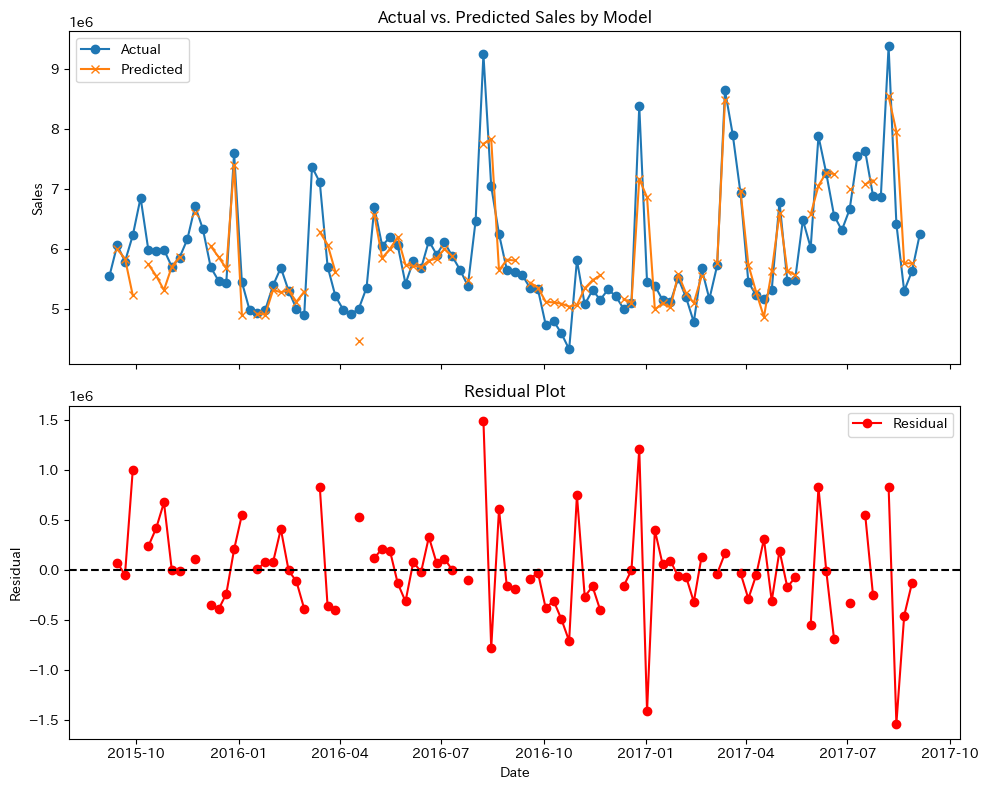

In [17]:
df_actual['Predicted'] = model.fittedvalues
df_actual['Residual'] = model.resid

df_actual.sort_values('Date', inplace=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

axes[0].plot(df_actual['Date'], df_actual['Sales'], label='Actual', marker='o')
axes[0].plot(df_actual['Date'], df_actual['Predicted'], label='Predicted', marker='x')
axes[0].set_ylabel('Sales')
axes[0].set_title('Actual vs. Predicted Sales by Model')
axes[0].legend()

axes[1].plot(df_actual['Date'], df_actual['Residual'], label='Residual', color='red', marker='o')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_ylabel('Residual')
axes[1].set_xlabel('Date')
axes[1].set_title('Residual Plot')
axes[1].legend()

plt.tight_layout()
plt.show()

# Insight

1. Model Fit (Training Data)
- R² = 0.762 and Adjusted R² = 0.696 on the training set.
This indicates that around 76% of the variance in Sales is explained by the chosen predictors and seasonal/holiday dummy variables. It’s a reasonably strong fit, albeit with a gap between R² and the Adjusted R², suggesting some predictors may be less informative or highly correlated.
- Overall Significance: The F-statistic is significant (p \approx 5.86e-14), confirming that, collectively, the predictors have a statistically meaningful relationship with Sales.

2. Key Predictors
- TVCM_GPR_residual (≈ 1391.69, p = 0.002)
This coefficient is significant, implying the decayed TVCM variable strongly correlates with increased Sales. The residual effect approach appears valuable for capturing persistent influence from past TVCM investments.
- Print_Media_residual (≈ 0.0098, p = 0.036)
A modest but statistically significant positive effect, suggesting incremental Print Media spending correlates with higher Sales when residual effects are considered.
- Offline_Ads_Lag1_residual (≈ 0.0105, p = 0.508)
Not significant. Shifting Offline Ads by one week and applying residual effects did not show a strong or clear positive/negative impact on Sales for this dataset.
- Digital_Ads_residual (≈ 8.48, p = 0.127)
Not statistically significant at the 5% level, though the positive sign indicates digital advertising might still play a role in boosting Sales. Additional data or a different model structure might clarify its exact effect.

3. Seasonal and Holiday Dummies
- Some Monthly Dummies (e.g., 3月, 5月, 7月, 9月, 10月, 11月)
These show statistically significant positive effects, hinting that these specific months see higher Sales on average compared to the baseline month (likely 1月 if omitted).
- Holiday Variables (正月, GW, お盆)
All are strongly significant and positive, indicating that these special periods (New Year, Golden Week, Obon) consistently drive up Sales.

4. Model Diagnostics
- Condition Number (~2.22e+08)
Very high, suggesting multicollinearity among predictors and dummies. This can inflate standard errors and destabilize coefficient estimates.
- Omnibus/Jarque-Bera Tests
The Omnibus test (p = 0.043) and Jarque-Bera test (p ~ 0.005) suggest some departure from normality in the residuals. While not always fatal for prediction, it can affect inference validity.
- Durbin-Watson (~2.335)
Indicates little autocorrelation in the residuals, which is generally good.

5. Test Set Performance
- Test RMSE ≈ 508,062
On average, the model’s predicted Sales deviate by ~508k units from actual test values. Whether this is acceptable depends on the Sales scale (if Sales are in the multi-millions, this might be reasonable).
- Test R² ≈ 0.662
About 66% of the variance is explained on unseen data, which is fairly solid and close to the training performance, indicating decent generalization.

◾️ Overall Insight
- The decayed (residual) variables for advertising, along with seasonal/holiday dummies, yield a model that explains a substantial portion of Sales variance.
- TVCM_GPR_residual and certain months/holiday dummies are particularly strong, while Offline_Ads_lag1_residual and Digital_Ads_residual are less conclusive.
- The high condition number points to potential multicollinearity among monthly/holiday dummy variables and advertising measures. Reducing the number of dummies (e.g., dropping one month or combining months) or applying a regularization technique (e.g., Ridge/Lasso) may stabilize estimates.
- The test R² around 0.66 suggests the model generalizes reasonably well to new data, but further refinement (e.g., addressing multicollinearity, exploring non-linear relationships) could improve predictive accuracy even more.

# Forecast

Forecast Results:
      Date  Forecast_Sales
2017-09-11    6.267181e+06
2017-09-18    6.429903e+06
2017-09-25    6.180449e+06
2017-10-02    5.807398e+06
2017-10-09    5.772122e+06
2017-10-16    5.550489e+06
2017-10-23    5.292083e+06
2017-10-30    5.740845e+06
2017-11-06    5.865573e+06
2017-11-13    6.024341e+06
2017-11-20    6.468519e+06
2017-11-27    6.310092e+06
2017-12-04    5.952146e+06
2017-12-11    5.831885e+06
2017-12-18    5.647970e+06
2017-12-25    7.727198e+06


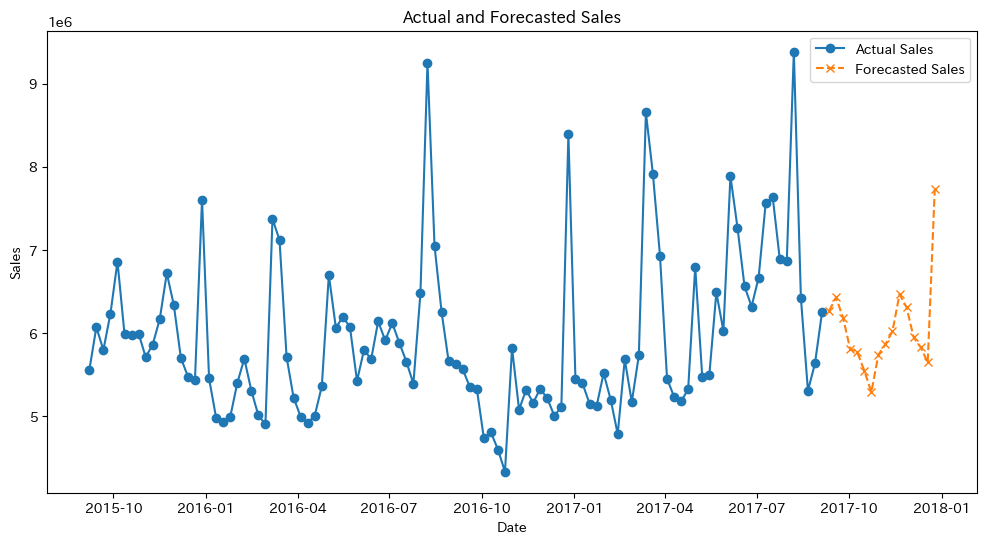

In [18]:
df_actual_combined = pd.concat([df_actual.loc[X_train.index], df_actual.loc[X_test.index]])
df_actual_combined = df_actual_combined.sort_values('Date')

monthly_dummy = [f'{i}月' for i in range(2, 13)]
holiday_dummy = ['正月', 'GW', 'お盆']
X_forecast = df_forecast[['TVCM_GPR_residual', 'Print_Media_residual', 'Offline_Ads_Lag1', 'Digital_Ads_residual'] + monthly_dummy + holiday_dummy]
X_forecast = sm.add_constant(X_forecast)

df_forecast['Forecast_Sales'] = model.predict(X_forecast)

df_combined = pd.concat([df_actual_combined, df_forecast])
df_combined = df_combined.sort_values('Date')

print("Forecast Results:")
print(df_forecast[['Date', 'Forecast_Sales']].to_string(index=False))

plt.figure(figsize=(12,6))
plt.plot(df_actual_combined['Date'], df_actual_combined['Sales'], label='Actual Sales', marker='o')
plt.plot(df_forecast['Date'], df_forecast['Forecast_Sales'], label='Forecasted Sales', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual and Forecasted Sales')
plt.legend()
plt.show()